# **IRIS 붓꽃 분류: Using KNN**

## **1. 패키지 Import**

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **2. 데이터 불러오기**

In [25]:
# Load the dataset
wine_data = pd.read_csv('wine.csv', delimiter=';')

# Inspect the dataset
print(wine_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

## **3. 학습/검증 데이터 분리 및 특징 선택**

In [26]:
from sklearn.model_selection._split import train_test_split

In [27]:
# Select specific features and target
features = ['alcohol', 'volatile acidity']
X = wine_data[features]
y = wine_data['quality']

In [28]:
# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279, 2) (320, 2) (1279,) (320,)


## **5. DecisionTree 모델 객체 생성**

* 데이터 선택: X_train/X_test, X_train_ss/X_test_ss

In [29]:
X_train = X_train
X_test = X_test

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

* **모델의 하이퍼 파라미터 불러오기**

In [32]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

* **하이퍼 파라미터 튜닝**

In [33]:
model = DecisionTreeClassifier(
    max_depth = 100,          # 5, 10 등
    # max_leaf_nodes = 100,     # 2~100 등
    min_samples_leaf = 1,  # 2~100 등
    min_samples_split = 2,  # 2~100 등
    criterion = 'entropy',     # 'gini', 'entropy' 등
)

In [34]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=100)

* **GridSearch를 통한 하이퍼파라미터 튜닝**

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
param_grid = {
    "max_depth"      : [5, 10],
    "max_leaf_nodes"  : [2, 10, 50],
    "min_samples_split" : [2, 10, 50],
    "criterion" : ["gini", "entropy"]
}

grid_model = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=2,   # K-fold
    refit=True)

In [37]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              max_depth=100),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10],
                         'max_leaf_nodes': [2, 10, 50],
                         'min_samples_split': [2, 10, 50]})

In [38]:
# GridSearch 결과 중, 최적 하이퍼파라미터 학습 모델 객체 반환
print(grid_model.best_params_)
best_model = grid_model.best_estimator_

{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_split': 2}


## **6. 모델 평가하기**

* 모델 선택: model, best_model

In [39]:
# model = model
model = best_model

In [40]:
from sklearn.metrics import accuracy_score

In [41]:
y_pred = model.predict(X_test)
print(f'분류 정확도: {accuracy_score(y_test, y_pred)}')

분류 정확도: 0.51875


In [42]:
from sklearn.metrics import classification_report

In [43]:
# Unique classes for target names
quality_labels = sorted(np.unique(y_test))  # Ensure labels are sorted

# Generate classification report
print(classification_report(
    y_test,
    y_pred,
    target_names=[f'Quality {label}' for label in quality_labels]
))

              precision    recall  f1-score   support

   Quality 3       0.00      0.00      0.00         1
   Quality 4       0.00      0.00      0.00        10
   Quality 5       0.58      0.77      0.66       130
   Quality 6       0.48      0.42      0.45       132
   Quality 7       0.33      0.26      0.29        42
   Quality 8       0.00      0.00      0.00         5

    accuracy                           0.52       320
   macro avg       0.23      0.24      0.23       320
weighted avg       0.48      0.52      0.49       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* Feature importance 확인

<Axes: >

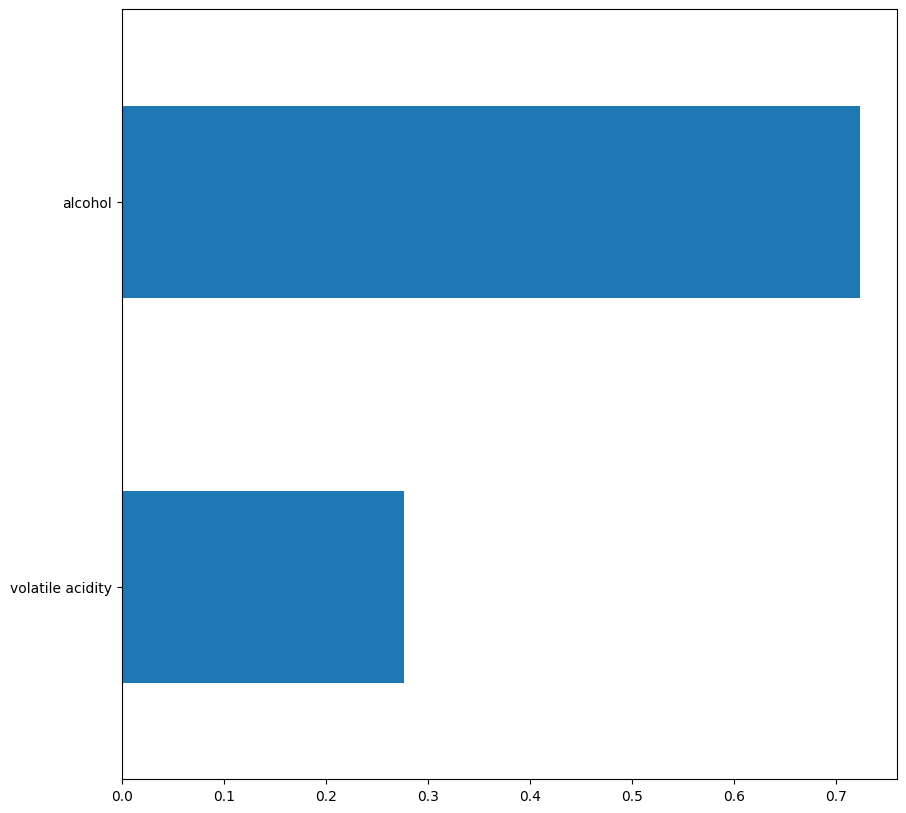

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
# 특성 중요도 파악
# 특성 중요도 계산 후 X_test column으로 넣는다.
importance = pd.Series(model.feature_importances_, X_test.columns)
importance.sort_values().plot.barh()

## **7. 시각화**

> **주의**
> * 2차원으로 시각화 하기 때문에 특징을 2개를 사용하여 학습한 모델만 사용할 것

In [45]:
from matplotlib.colors import ListedColormap

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


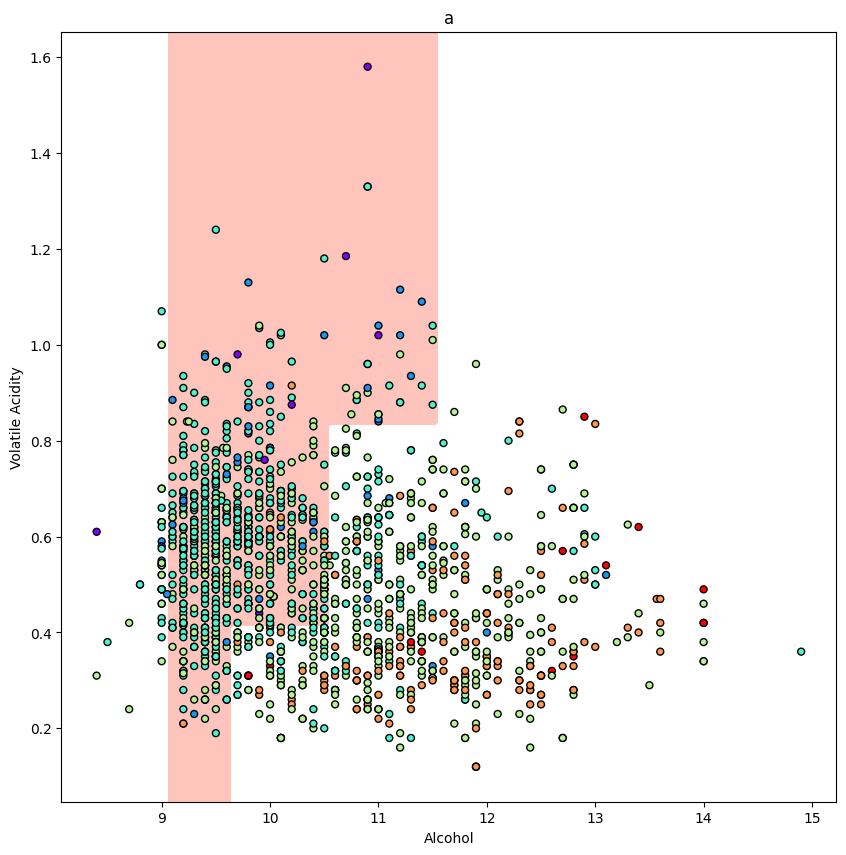

In [46]:
import numpy as np

plt.rcParams['figure.figsize'] = (10, 10)

def visualize_boundary(model, X, y, title, xlabel, ylabel):
    ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k', zorder=3)
    ax.axis('tight')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5,cmap='rainbow',zorder=1)
    plt.title(title)
    plt.xlabel('Alcohol')  # x축 이름 설정
    plt.ylabel('Volatile Acidity')  # y축 이름 설정

visualize_boundary(model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]), 'a', 'a','a')